In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import joblib
import os
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("ObesityDataSet.csv")


In [4]:
# Map binary string features to numeric
binary_map = {'yes': 1, 'no': 0}
binary_features = ['FAVC','SMOKE','SCC','family_history_with_overweight']
for col in binary_features:
    df[col] = df[col].map(binary_map)

In [5]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y) 

In [7]:
# -------------------------
# Train/Test split (80/20)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [8]:
# -------------------------
# Define feature types
# -------------------------
# Feature lists
numeric_features = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
categorical_features = ['Gender','CAEC','CALC','MTRANS']


In [9]:
# -------------------------
# Preprocess
# -------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'  # leaves binary features unchanged
)

=== XGBoost Evaluation Metrics ===
Accuracy: 0.9551
AUC Score: 0.9977
Precision: 0.9572
Recall: 0.9551
F1 Score: 0.9555
MCC Score: 0.9478


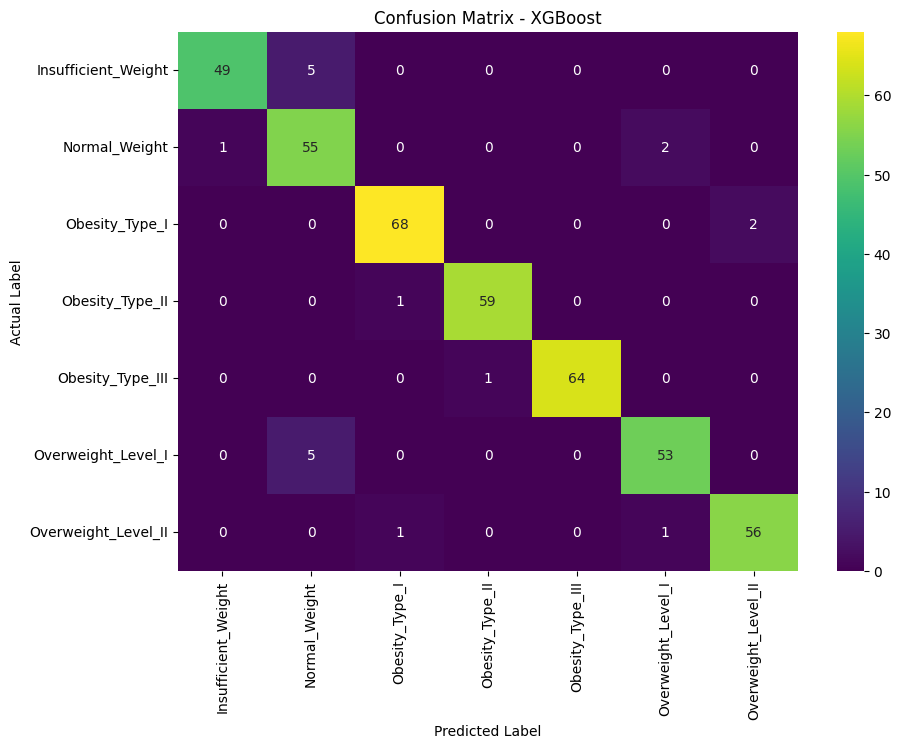

In [10]:
# -------------------------
# 2. Build and train XGBoost model
# -------------------------
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softprob',   # multi‑class with probabilities
        num_class=7,                  # because there are 7 obesity labels
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)

# -------------------------
# 3. Predictions and probabilities
# -------------------------
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)  # probabilities for AUC

# -------------------------
# 4. Evaluation Metrics
# -------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)
auc = roc_auc_score(
    pd.get_dummies(y_test),    # one‑vs‑rest encoding of truth
    y_prob,
    multi_class='ovr',
    average='weighted'
)

print("=== XGBoost Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")

# -------------------------
# 5. Confusion Matrix
# -------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [11]:
os.makedirs('model', exist_ok=True)

# Save the entire pipeline (preprocessor + XGBoost model)
joblib.dump(xgb_model, 'model/xgboost_pipeline.pkl')

['model/xgboost_pipeline.pkl']